###Instalación de las librerías

In [ ]:
!pip install pint

In [ ]:
# download modsim.py if necessary

from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)

download('https://github.com/AllenDowney/ModSimPy/raw/master/' +
         'modsim.py')

In [ ]:
# import functions from modsim
from modsim import *

https://gabdlr.github.io/leaflet-coordinates-locator/

# Modelo SIR

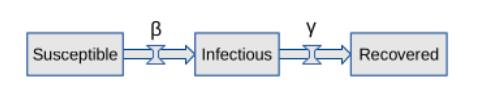

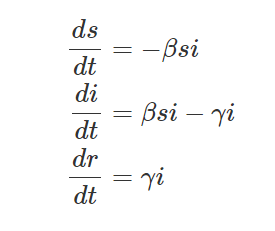

Donde:\
β = 1 / tc

γ = 1 / tr

*tc* es el tiempo entre eventos de contacto (cuántos días existen entre  contactos consecutivos).\
*tr* es el tiempo de recuperación.\
*β* es la tasa de contacto.\
*γ* es tasa de recuperación.

### Modelo inicial

Representamos el estado inicial del sistema, con las categorías y poblaciones en cada una de ellas. Utilizamos el objeto State()

In [ ]:
import modsim as ms

estado = ms.State(s=89, i=1, r=0) #N=90 personas
estado

s    89
i     1
r     0
Name: state, dtype: int64

In [ ]:
#Dividimos la población en cada categoría por la población total
# para trabajar con porcentajes de población (no con cantidad de personas)
estado = estado / estado.sum() # Se normaliza de acuerdo al número total de la población
estado

s    0.988889
i    0.011111
r    0.000000
Name: state, dtype: float64

In [ ]:
tc = 3             # Tiempo entre contactos (días)
tr = 4             # tiempo de recuperación (días)

In [ ]:
beta = 1 / tc
gamma = 1 / tr

In [ ]:
def make_system(beta, gamma):
  estado = ms.State(s=89, i=1, r=0)
  estado = estado / estado.sum()

  return ms.System(estado=estado, t_end=7*14,     # porque considera un semestre de clases, serían 98 días.
                beta=beta, gamma=gamma)

In [ ]:
system = make_system(beta, gamma)
system

namespace(estado=s    0.988889
                 i    0.011111
                 r    0.000000
                 Name: state, dtype: float64,
          t_end=98,
          beta=0.3333333333333333,
          gamma=0.25)

Definimos las función de actualización, que toma el estado actual de un sistema y calcular el estado para el siguiente paso de tiempo.

In [ ]:
def step(t, state, system):
    s, i, r = state.s, state.i, state.r #asigna los valores que tiene state a las variables para simplificar la lectura del código.

    infected = system.beta * i * s
    recovered = system.gamma * i

    s -= infected
    i += infected - recovered
    r += recovered

    return ms.State(s=s, i=i, r=r) #actualiza el estado y lo retorna

Función para la simulación, calcula la función step() durante el paso de tiempo.

In [ ]:
def run_simulation1(system, update_func):
    state = system.estado #Contiene el estado incial

    for t in range(0, system.t_end):
        state = update_func(t, state, system)

    return state

In [ ]:
final_state = run_simulation1(system, step)
final_state #Luego de la simulación, al final del semestre obtenemos estos estados

s    0.520568
i    0.000666
r    0.478766
Name: state, dtype: float64

Conclusión:\
Después de 98 días, alrededor del 52% de la población sigue siendo susceptible, lo que significa que nunca se infectaron; aproximadamente el 48% se ha recuperado, lo que significa que se infectaron en algún momento y luego se recuperaron; y menos del 1% están infectados actualmente.\
Si queremos conocer el números de personas que representan los porcentajes, los multiplicamos por el total de la población.

In [ ]:
final_state*90

s    46.851127
i     0.059923
r    43.088950
Name: state, dtype: float64



*   47 personas sin infectarse.
*   43 personas se infectaron y ya se recuperaron.





### Series temporales

Para visualizar cómo se comporta el modelo entre el tiempo inicial y el final, guardamos los resultados en series temporales y las graficamos.

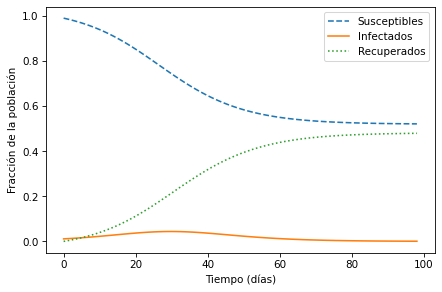

In [ ]:
import matplotlib.pyplot as plt

def run_simulation2(system, update_func):
    S = ms.TimeSeries()
    I = ms.TimeSeries()
    R = ms.TimeSeries()

    state = system.estado
    S[0], I[0], R[0] = state #guardamos las condiciones iniciales en la primer fila de cada serie temporal

    for t in range(0, system.t_end):
        state = update_func(t, state, system)
        S[t+1], I[t+1], R[t+1] = state.s, state.i, state.r

    return S, I, R

def plot_results(S, I, R):
    plt.plot(S, '--', label="Susceptibles")
    plt.plot(I,'-', label='Infectados')
    plt.plot(R,':', label='Recuperados')
    ms.decorate(xlabel='Tiempo (días)', ylabel='Fracción de la población')

S, I, R = run_simulation2(system, step)
plot_results(S, I, R)

El brote tarda unos 18 días en aparecer y unos 35 días en alcanzar su punto máximo. La fracción de la población que está infectada nunca es muy alta. ¿Cómo podríamos calcular la población total que se enfermó?

Sustituimos las tres series temporales por un objeto que almacena varias series temporales que comparten las mismas variables, este nuevo objeto se llama TimeFrame().

In [ ]:
system.estado.index

Index(['s', 'i', 'r'], dtype='object')

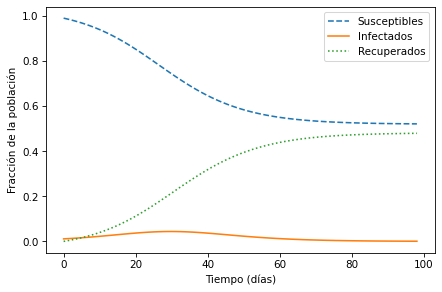

In [ ]:
def run_simulation(system, update_func):

    frame = ms.TimeFrame(columns=system.estado.index) #definimos el timeFrame con columnas que serán los índices de estado.

    frame.loc[0] = system.estado # en la primer fila del dataframe guardamos los valores iniciales de las variables de estado

    for t in range(0, system.t_end):
        frame.loc[t+1] = update_func(t, frame.loc[t], system) #calcula la población para el sgte. paso del tiempo con la función de actualización.

    return frame

results = run_simulation(system, step)
#print(results.head())
plot_results(results.s, results.i, results.r)

In [ ]:
results.head()*90

,s,i,r
0,89.000000,1.000000,0.000000
1,88.670370,1.079630,0.250000
2,88.315811,1.164282,0.519907
3,87.934979,1.254043,0.810978
4,87.526556,1.348955,1.124489


In [ ]:
results.tail()*90

,s,i,r
94,46.902095,0.082337,43.015569
95,46.887792,0.076055,43.036153
96,46.874584,0.070249,43.055167
97,46.862388,0.064883,43.072729
98,46.851127,0.059923,43.088950


### ¿Cómo podríamos calcular la población total que se enfermó?

In [ ]:
89-47

42

In [ ]:
results.s.loc[0]

0.9888888888888889

In [ ]:
results.s.loc[system.t_end]

0.520568077860108

In [ ]:
results.s[system.t_end]

0.520568077860108

In [ ]:
#opción 1
s_inicial = results.s.loc[0]
s_final = results.s.loc[system.t_end]
s_total = s_inicial - s_final
s_total*90

42.14887299259029

In [ ]:
r_final = results.r.loc[system.t_end]
i_final = results.i.loc[system.t_end]
(r_final + i_final)*90

43.1488729925903

## Ejercicio
1. Suponga que el tiempo entre contactos es de 4 días y el tiempo de recuperación es de 5 días. Al final del semestre, ¿cuántos estudiantes, en total, se han infectado?
2. Suponga que el tiempo entre contactos es de 2 días y la tasa de recuperación es de 6 días. ¿Cómo se comporta el modelo?¿cuántos estudiantes, en total, se han infectado?
3. Realice una simulación estableciendo tasas que lleven a un comportamiento del modelo que le interese destacar.  

### Caso 1

Realizamos la simulacion con un tiempo entre contactos de 4 días y un tiempo de recuperación de 5 días.

In [ ]:
tc = 4             # Tiempo entre contactos (días)
tr = 5             # Tiempo de recuperación (días)

In [296]:
b = 1 / tc
g = 1 / tr

# Realiza el sistema
def make_system(beta, gamma):
  estado = ms.State(s=89, i=1, r=0)
  estado = estado / estado.sum()

  return ms.System(estado=estado, t_end=7*14,
                beta=beta, gamma=gamma)

# Actualiza los estados
def step(t, state, system):
    s, i, r = state.s, state.i, state.r

    infected = system.beta * i * s
    recovered = system.gamma * i

    s -= infected
    i += infected - recovered
    r += recovered

    return ms.State(s=s, i=i, r=r)

# Corremos la simulación
def run_simulation(system, update_func):
    state = system.estado

    for t in range(0, system.t_end):
        state = update_func(t, state, system)

    return state

# Corremos la simulacion utilizando series temporales para luego poder visualizarlas
def run_simulation_ts(system, update_func):
    S = ms.TimeSeries()
    I = ms.TimeSeries()
    R = ms.TimeSeries()

    state = system.estado
    S[0], I[0], R[0] = state

    for t in range(0, system.t_end):
        state = update_func(t, state, system)
        S[t+1], I[t+1], R[t+1] = state.s, state.i, state.r

    return S, I, R

system = make_system(b, g)
results = run_simulation(system, step)
S, I, R = run_simulation_ts(system, step)
results

s    0.610171
i    0.004672
r    0.385157
Name: state, dtype: float64

Conclusion: tenemos una simulación bastante uniforme con respecto a las tasas de contacto y recuperación. El resultado es que un 38% de la población se infecto y teniendo una recuperacion exitosa. Mientras que un 61% nunca se infecto.

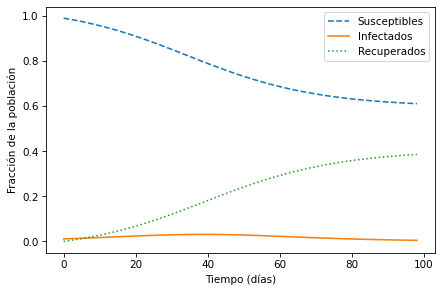

In [297]:
# Ploteamos los resultados
def plot_results(S, I, R):
    plt.plot(S, '--', label="Susceptibles")
    plt.plot(I,'-', label='Infectados')
    plt.plot(R,':', label='Recuperados')
    ms.decorate(xlabel='Tiempo (días)', ylabel='Fracción de la población')

plot_results(S, I, R)

In [298]:
results*90

s    54.915403
i     0.420483
r    34.664114
Name: state, dtype: float64

Resultados:

* 55 personas sin infectarse
* 35 personas que se infectaron y ya se recuperaron.

### Caso 2

Realizamos la simulacion con un tiempo entre contactos de 2 días y un tiempo de recuperación de 6 días.

In [300]:
tc = 2             # Tiempo entre contactos (días)
tr = 6             # Tiempo de recuperación (días)

In [301]:
b = 1 / tc
g = 1 / tr

# Realiza el sistema
def make_system(beta, gamma):
  estado = ms.State(s=89, i=1, r=0)
  estado = estado / estado.sum()

  return ms.System(estado=estado, t_end=7*14,
                beta=beta, gamma=gamma)

# Actualiza los estados
def step(t, state, system):
    s, i, r = state.s, state.i, state.r

    infected = system.beta * i * s
    recovered = system.gamma * i

    s -= infected
    i += infected - recovered
    r += recovered

    return ms.State(s=s, i=i, r=r)

# Corremos la simulación
def run_simulation(system, update_func):
    state = system.estado

    for t in range(0, system.t_end):
        state = update_func(t, state, system)

    return state

# Corremos la simulacion utilizando series temporales para luego poder visualizarlas
def run_simulation_ts(system, update_func):
    S = ms.TimeSeries()
    I = ms.TimeSeries()
    R = ms.TimeSeries()

    state = system.estado
    S[0], I[0], R[0] = state

    for t in range(0, system.t_end):
        state = update_func(t, state, system)
        S[t+1], I[t+1], R[t+1] = state.s, state.i, state.r

    return S, I, R

system = make_system(b, g)
results = run_simulation(system, step)
S, I, R = run_simulation_ts(system, step)
results

s    0.048185
i    0.000003
r    0.951812
Name: state, dtype: float64

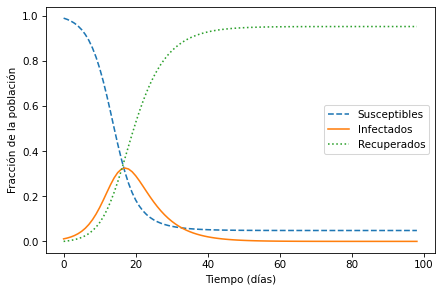

In [302]:
# Ploteamos los resultados
def plot_results(S, I, R):
    plt.plot(S, '--', label="Susceptibles")
    plt.plot(I,'-', label='Infectados')
    plt.plot(R,':', label='Recuperados')
    ms.decorate(xlabel='Tiempo (días)', ylabel='Fracción de la población')

plot_results(S, I, R)

Conclusion: tenemos un mayor porcentaje de infectados con respecto a un determinado tiempo (alrededor de 17 días), porque la mayor parte de la población se infecta. Vemos que un gran porcentaje de la población (95%) logra recuperarse con exito en su totalidad.

In [303]:
results*90

s     4.336638
i     0.000247
r    85.663116
Name: state, dtype: float64

Resultados:

* 4 personas sin infectarse
* 86 personas se infectaron y ya se recuperaron.

### Caso 3

Para este caso final realizaremos una simulación con un tiempo entre contactos de 5 días y un tiempo de recuperación de 10 días.

In [305]:
tc = 5             # Tiempo entre contactos (días)
tr = 10            # Tiempo de recuperación (días)

In [306]:
b = 1 / tc
g = 1 / tr

# Realiza el sistema
def make_system(beta, gamma):
  estado = ms.State(s=89, i=1, r=0)
  estado = estado / estado.sum()

  return ms.System(estado=estado, t_end=7*14,
                beta=beta, gamma=gamma)

# Actualiza los estados
def step(t, state, system):
    s, i, r = state.s, state.i, state.r

    infected = system.beta * i * s
    recovered = system.gamma * i

    s -= infected
    i += infected - recovered
    r += recovered

    return ms.State(s=s, i=i, r=r)

# Corremos la simulación
def run_simulation(system, update_func):
    state = system.estado

    for t in range(0, system.t_end):
        state = update_func(t, state, system)

    return state

# Corremos la simulacion utilizando series temporales para luego poder visualizarlas
def run_simulation_ts(system, update_func):
    S = ms.TimeSeries()
    I = ms.TimeSeries()
    R = ms.TimeSeries()

    state = system.estado
    S[0], I[0], R[0] = state

    for t in range(0, system.t_end):
        state = update_func(t, state, system)
        S[t+1], I[t+1], R[t+1] = state.s, state.i, state.r

    return S, I, R

system = make_system(b, g)
results = run_simulation(system, step)
S, I, R = run_simulation_ts(system, step)
results

s    0.203216
i    0.014568
r    0.782216
Name: state, dtype: float64

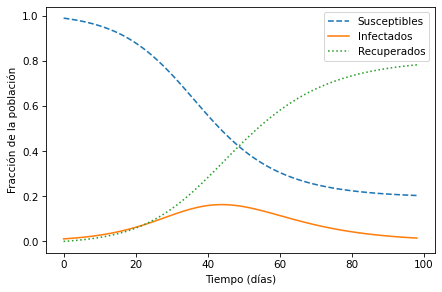

In [ ]:
# Ploteamos los resultados
def plot_results(S, I, R):
    plt.plot(S, '--', label="Susceptibles")
    plt.plot(I,'-', label='Infectados')
    plt.plot(R,':', label='Recuperados')
    ms.decorate(xlabel='Tiempo (días)', ylabel='Fracción de la población')

plot_results(S, I, R)

Conclusion: para este ultimo caso, utilizando un valor de tiempo medio para contactos y el doble para recuperación, podemos visualizar que no ocurre una diferencia notable con respecto a los dos casos anteriores.

En este caso, el 78% de la población se infecto pero logro recuperarse con exito, mientras que un 20% nunca se infecto y un 1% de personas sigue infectada.

In [ ]:
results*90

s    18.289444
i     1.311089
r    70.399467
Name: state, dtype: float64

Resultados:

* 18 personas nunca se infectaron
* 1 persona sigue infectada
* 71 personas se infectaron y ya se recuperaron

## Inmunización


*   ¿Qué pasaría si un porcentaje de la población se vacuna?
*   ¿Qué pasaría si un porcentaje de la población se lavara las manos regularmente?




Consideremos el primer punto, donde existe una vacuna que vuelve inmune a un estudiante. Es decir, el estudiante inmunizado no se infectará ¿Cómo podríamos modelar este efecto?

### Vacunación

Una manera de representar esta situación es, considerar los estudiantes vacunados como recuperados, ya que éstos no se puede volver a infectar.

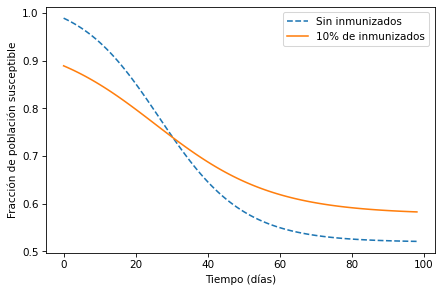

In [ ]:
import modsim as ms
import matplotlib.pyplot as plt


tc = 3             # Tiempo entre contactos (días)
tr = 4             # Tiempo de recuperación (días)
beta = 1 / tc      # Tasa de contagios
gamma = 1 / tr     # Tasa de recuperación

def make_system(beta, gamma):

  estado = ms.State(s=89, i=1, r=0)
  estado = estado / estado.sum()

  return ms.System(estado=estado, t_end=7*14,
                beta=beta, gamma=gamma)

def step(t, state, system):
    '''
    Calcula las categorías de la población según las ecuaciones del modelo SIR KM
    '''
    s, i, r = state.s, state.i, state.r #para simplificar la lectura del código y leer state en varias líneas
    infected = system.beta * i * s
    recovered = system.gamma * i
    s -= infected
    i += infected - recovered
    r += recovered

    return ms.State(s=s, i=i, r=r)

def run_simulation(system, update_func):

    frame = ms.TimeFrame(columns=system.estado.index) #definimos el timeFrame con columnas que serán los índices de estado.
    frame.loc[0] = system.estado # en la primer fila del dataframe guardamos los valores iniciales de las variables de estado

    for t in range(0, system.t_end):
        frame.loc[t+1] = update_func(t, frame.loc[t], system) #calcula la población para el sgte. paso del tiempo con la función de actualización.
    return frame


def add_immunization(system, fraction):
    '''Innmuniza un porcentaje de población
    los suceptibles pasan a ser recuperados
    fraccion es un número entre 0 y 1 y representa la fracción que se inmuniza
    '''
    system.estado.s -= fraction
    system.estado.r += fraction

system = make_system(beta, gamma)
results = run_simulation(system, step) #sin inmunizados
#results.head()
#plot_results(results.s, results.i, results.r)

system2 = make_system(beta, gamma)
add_immunization(system2, 0.1)
results2 = run_simulation(system2, step) #con inmunizados

plt.plot(results.s,'--', label='Sin inmunizados')
plt.plot(results2.s,label='10% de inmunizados')
ms.decorate(xlabel='Tiempo (días)', ylabel='Fracción de población susceptible')

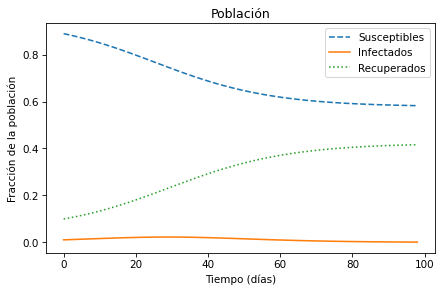

In [ ]:
plot_results(results2.s, results2.i, results2.r)
ms.decorate(title='Población')
#plot_results(results.s, results.i, results.r)
#ms.decorate(title='Población')

Conclusión:
con la inmunización hay menor cantidad de susceptibles, en consecuencia, los infectados se reducen.

### Calculamos el total de infectados:

In [ ]:
def calc_total_infected(resul, system):
    s_0 = resul.s[0]
    s_end = resul.s[system.t_end]
    return s_0 - s_end

print(calc_total_infected(results, system))
print(calc_total_infected(results2, system))

0.468320811028781
0.30650802853979753


Sin inmunización, casi el 47% de la población se infecta en algún momento. Con un 10% de inmunización, sólo el 31% se infecta.

### Barrido de inmunización
Calcularemos cómo se comporta el modelo en un rango de porcentajes de estudiantes vacunados.

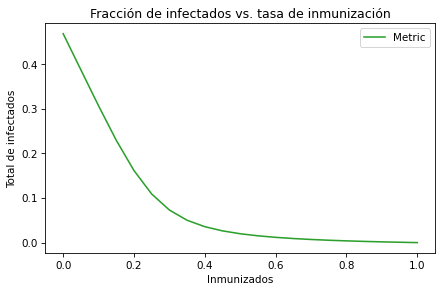

In [ ]:
def sweep_immunity(fraction_array):
    '''calcula para cada porcentaje de vacunación
       la fracción de estudiantes infectados
       fraction_array array de porcentajes de vacunación
    '''
    sweep = ms.SweepSeries()

    for fraction in fraction_array:
        system = make_system(beta, gamma)
        add_immunization(system, fraction)
        results = run_simulation(system, step)
        sweep[fraction] = calc_total_infected(results, system)

    return sweep

fraction_array = ms.linspace(0, 1, 21) # se incrementa cada 0.05
infected_sweep = sweep_immunity(fraction_array)


infected_sweep.plot(color='C2')

ms.decorate(xlabel='Inmunizados',
         ylabel='Total de infectados',
         title='Fracción de infectados vs. tasa de inmunización')

A medida que aumenta la tasa de inmunización, disminuye la cantidad de infectados.\
Si el 40% de los estudiantes están vacunados, menos del 4% se enferma. Eso es porque la inmunización tiene dos efectos: protege a las personas que se inmunizan (por supuesto) pero también protege al resto de la población.

Reducir la cantidad de "susceptibles" y aumentar la cantidad de "resistentes" (recuperados) dificulta la propagación de la enfermedad, porque una fracción de los contactos se desperdicia en personas que no pueden infectarse. Este fenómeno se denomina inmunidad colectiva y es un elemento importante de la salud pública.

La ventaja es que no tenemos que inmunizar a todos, ya que las vacunas pueden proteger al “rebaño” incluso si no son 100% efectivas.

Una pequeña disminución en la inmunización puede causar un gran aumento en los infectados. En este ejemplo, si bajamos del 80% de inmunización al 60%, no es tan significativo. Pero si bajamos del 40% al 20%, habría una gran diferencia en los contagios.



---



### Lavado de manos

In [ ]:
(300*10)/500

6.0

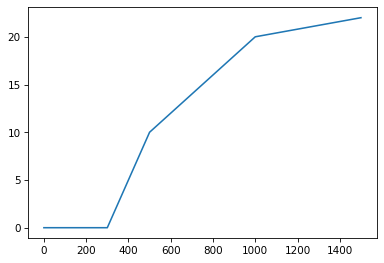

In [ ]:
gasto=[0,300, 500, 1000, 1500]
efecto=[0, 0, 10, 20, 22]
plt.plot(gasto,efecto)

Para modelar el efecto de la campaña de lavado de manos, se usa la función logística generalizada ([GLP](https://en.wikipedia.org/wiki/Generalised_logistic_function)), que es una función conveniente para modelar curvas que tienen una forma generalmente sigmoidea.


[   0.   70.  140.  210.  280.  350.  420.  490.  560.  630.  700.  770.
  840.  910.  980. 1050. 1120. 1190. 1260. 1330. 1400.]


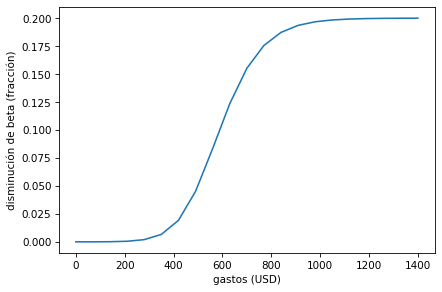

In [ ]:
from numpy import exp
from modsim import*

def logistic(x, A=0, B=1, C=1, M=0, K=1, Q=1, v=0.5):
    """Función logística generalizada. Parámetros:

    A: Asíntota inferior.
    B: tasa de crecimiento, inclinación de la transición.
    C: generalmente es 1. De lo contrario la asíntota cambia de valor según otra ec.
    M: valor de transición (punto de inflexión)
    K: Asíntota superior. Máximo valor de disminución de beta.
    Q: varía la transición a la derecha (3) o izquierda (0.5)
    v: simetría de transición
    x: gastos

    retorna: float or array
    """
    exponent = -B * (x - M)
    denom = C + Q * exp(exponent)
    return A + (K-A) / denom ** (1/v)

spending = ms.linspace(0, 1400, 21)
print(spending)
funcion = logistic(spending, M=500, K=0.2, B=0.01)
plt.plot(spending,funcion)
ms.decorate(title= '', xlabel= "gastos (USD)", ylabel="disminución de beta (fracción)")

In [ ]:
logistic(1000, M=500, K=0.2, B=0.01)

0.19733181848098505

In [ ]:
def compute_factor_beta(spending):
    """Reducción de beta en función al gasto.

    spending: de 0 a 1200 dólares

    returns: fracción en que se reduce beta
    """
    return logistic(spending, M=500, K=0.2, B=0.01)

spending = ms.linspace(0, 1200, 21) #Creamos un array con los posibles gastos (dinero invertido en la campaña)

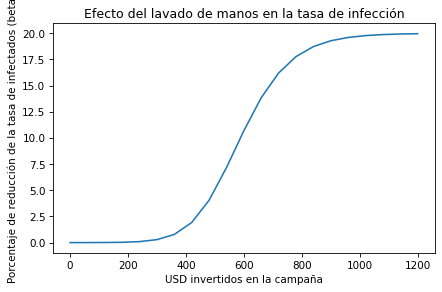

In [ ]:
percent_reduction = compute_factor_beta(spending) * 100
#print(percent_reduction)

plt.plot(spending, percent_reduction)
ms.decorate(xlabel='USD invertidos en la campaña',
         ylabel='Porcentaje de reducción de la tasa de infectados (beta)',
         title='Efecto del lavado de manos en la tasa de infección')

A medida que invierto dinero en la campaña el porcentaje de reducción de beta aumenta hasta un valor del 20% como máximo.

**Integro el lavado de manos en la simulación.**
Calculo el beta final para modelar el sistema con ese nuevo valor obtenido de acuerdo al dinero invertido. Ej.: Si tengo un beta de 0.5 e invierto 500 USD tengo que restarle a ese 0.5 un 10%.\
Volvemos a simular:

In [ ]:
def add_hand_washing(system, spending):
    '''Modela el efecto de lavarse las manos
       calculando en cto se reduce la tasa de contagio
    '''
    factor = compute_factor_beta(spending) # este es el factor en cto se reduce beta (en cto se va a reducir beta)
    system.beta *= (1 - factor) # calculo y asigno el nuevo valor de beta

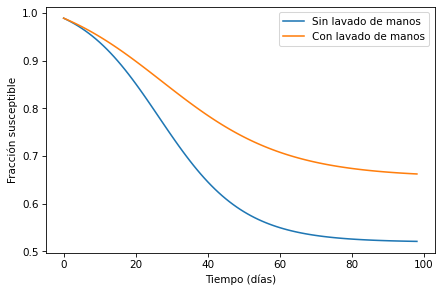

In [ ]:
tc=3
tr=4
beta=1/tc
gamma=1/tr

sistema=make_system(beta,gamma)
resultado = run_simulation(sistema, step)

add_hand_washing(sistema,600)
resultado2 = run_simulation(sistema, step)
#print(calc_total_infected(resultado2))
plt.plot(resultado.s, label ="Sin lavado de manos")
plt.plot(resultado2.s, label ="Con lavado de manos")
ms.decorate(xlabel="Tiempo (días)",ylabel="Fracción susceptible")

Ahora empieza con la misma cantidad de susceptibles, pero la tasa de contagio es menor gracias a invertir $600 en campaña de lavado de manos.\
¿Qué pasará si aumento el dinero que invierto?

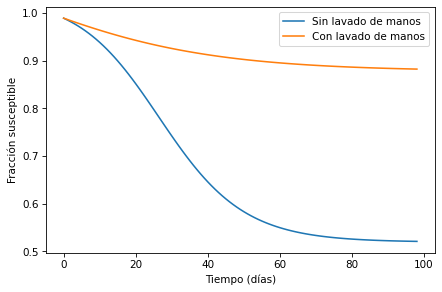

In [ ]:
add_hand_washing(sistema, 800) #Invierto 800 por ej.
resultado2 = run_simulation(sistema, step)
#print(calc_total_infected(system,resultado2))
plt.plot(resultado.s, label ="Sin lavado de manos")
plt.plot(resultado2.s, label ="Con lavado de manos")
ms.decorate(xlabel="Tiempo (días)",ylabel="Fracción susceptible")

Disminuye en menor proporción la fracción de susceptibles



---



### Optimización

In [ ]:
num_students = 90
budget = 1200         #presupuesto máximo
price_per_dose = 100  #vacunas
max_doses = int(budget / price_per_dose) #máx de dosis que podemos comprar
max_doses

12

In [ ]:
dose_array = linrange(max_doses) #arreglo de dosis
dose_array

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.])

In [ ]:
def sweep_doses(dose_array):
    sweep = SweepSeries()

    for doses in dose_array:
        fraction = doses / num_students #fracción de estudiantes que estamos vacunando
        spending_disponible = budget - doses * price_per_dose # cantidad de dosis por precio c/u, nos da el total invertido en vacunas

        system = make_system(beta, gamma)
        add_immunization(system, fraction)
        add_hand_washing(system, spending_disponible)

        results = run_simulation(system, step)
        sweep[doses] = calc_total_infected(results, system)

    return sweep

In [ ]:
infected_sweep3 = sweep_doses(dose_array)

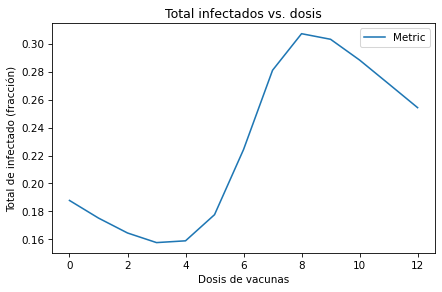

In [ ]:
infected_sweep3.plot()

ms.decorate(xlabel='Dosis de vacunas',
         ylabel='Total de infectado (fracción)',
         title='Total infectados vs. dosis')

Al compartir el presupuesto entre las dosis aplicadas (que van de 0 a 12) y el lavado de manos, resulta lo siguiente:

Llega un momento en el que aumentar la cantidad de vacunas no disminuye tanto los infectados, esto pasa porque llegamos a un punto donde la campaña de manos ya no tiene efecto en la reducción del beta y nuestro beta empieza a aumenta. Con sólo las vacunas no nos alcanzaría para disminuir los infectados.- Luego cuando las vacunas son muchas tienen efectos en la disminucion de los infectados.
Se podría concluir que la primer parte de la cuerva predomina el efecto de la campaña de lavado de manos y en la segunda parte la de vacunación.
Juntas se obtiene el valor óptimo que es con 4 dosis de vacunas.-

## Barriendo parámetros

###Barriendo beta

Para ver cómo varía el modelo al variar beta,es decir, la tasa de contagio/contacto, vamos a crear un array de valores de beta con linspace.\
Gamma (tasa de recuperación) toma un valor fijo.

In [ ]:
beta_array = linspace(0.1, 1.1, 11)
gamma = 0.25

Creamos una función que tome un valor de beta del arreglo, ejecute la simulación y calcule para esa simulación la cantidad de infectados.

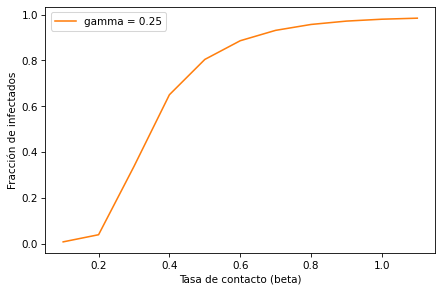

In [ ]:
def sweep_beta(beta_array, gamma):
    sweep = SweepSeries()
    for beta in beta_array:
        system = make_system(beta, gamma)
        results = run_simulation(system, step)
        sweep[beta] = calc_total_infected(results, system)
    return sweep

infected_sweep = sweep_beta(beta_array, gamma)
infected_sweep.plot(label="gamma = 0.25", color='C1')

decorate(xlabel='Tasa de contacto (beta)',
         ylabel='Fracción de infectados')

Cuando beta es pequeño, la tasa de contacto es baja y el brote nunca se alcanza; el número total de estudiantes infectados es casi cero. A medida que beta aumenta y alcanza un umbral cercano a 0,3, la fracción de estudiantes infectados aumenta rápidamente. Y si beta supera el 0,5, más del 80% de la población esta infectada.


###Barriendo gamma

Barremos gamma para cada uno de los valores de beta y calculamos la cantidad de infectados. Esto se denomina barrido en dos dimensiones.

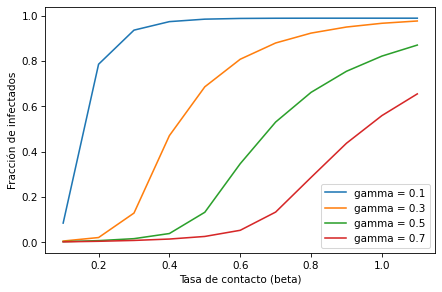

In [ ]:
gamma_array = linspace(0.1, 0.7, 4)
gamma_array

for gamma in gamma_array:
    infected_sweep = sweep_beta(beta_array, gamma)
    label = f'gamma = {gamma}'
    infected_sweep.plot(label=label)

decorate(xlabel='Tasa de contacto (beta)',
         ylabel='Fracción de infectados')

Cuando gamma es bajo, la tasa de recuperación es baja, lo que significa que las personas permanecen infectadas por más tiempo. En ese caso, incluso una tasa de contacto baja (beta) resulta en una epidemia.

Cuando gamma es alto, y beta tiene es aún más alto la fracción de población infectada empieza a aumentar.

### SweepFrame
Almacenamos los valores en un data frame, donde las filas barren un parámetro, las columnas barren otro parámetro y la intersección contiene el valor de una métrica (la cantidad de infectados).

In [ ]:
def sweep_parameters(beta_array, gamma_array):
    frame = SweepFrame(columns=gamma_array) #Columnas está gamma
    for gamma in gamma_array:
        frame[gamma] = sweep_beta(beta_array, gamma) #filas se guardan los beta
    return frame

En el SweepFrame almacena los resultados, con una columna para cada valor de gamma y una fila para cada valor de beta. Los resultados es la fracción de infectados para cada par de parámetros.

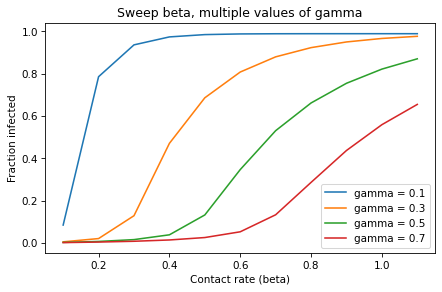

In [ ]:
frame = sweep_parameters(beta_array, gamma_array)

for gamma in gamma_array:
    label = f'gamma = {gamma}'
    frame[gamma].plot(label=label)

decorate(xlabel='Contact rate (beta)',
         ylabel='Fraction infected',
         title='Sweep beta, multiple values of gamma')

Con los datos ya almacendos vamos a realizar un "*gráfico de contorno*" donde vemos los parámetros en los ejes y las líneas de contorno donde el valor de la métrica es constante.\
Las columnas del frame se grafican en el eje x y las filas en el eje y y se dibujan líneas donde los valores de infectados son iguales para el par de parámetros.

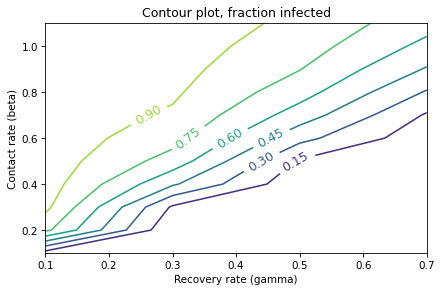

In [ ]:
contour(frame)

decorate(xlabel='Recovery rate (gamma)',
         ylabel='Contact rate (beta)',
         title='Contour plot, fraction infected')

Las tasas de infección son más bajas en la parte inferior derecha, donde la tasa de contacto es baja y la tasa de recuperación es alta. Aumentan a medida que avanzamos hacia la parte superior izquierda, donde la tasa de contacto es alta y la tasa de recuperación es baja.\
Los resultados que visualizamos en el gráfico sugieren que existe una relación entre los dos parámetros que determina el resultado del modelo.

## Análisis


*   Cuando beta y gamma son iguales obtenemos alrededor del 13% de infectados.
*   Si beta excede a gamma voy a tener más contactos que recueraciones, entonces la tasa de contacto va a ir aumentado.



In [ ]:
beta_array = [0.1, 0.2, 0.3, 0.4, 0.5,
              0.6, 0.7, 0.8, 0.9, 1.0 , 1.1]
gamma_array = [0.2, 0.4, 0.6, 0.8]

frame = sweep_parameters(beta_array, gamma_array)
frame.head()

,0.2,0.4,0.6,0.8
Parameter,,,,
0.1,0.010756,0.003642,0.002191,0.001567
0.2,0.118984,0.010763,0.005447,0.003644
0.3,0.589095,0.030185,0.010771,0.006526
0.4,0.801339,0.131563,0.020917,0.010780
0.5,0.896577,0.396409,0.046140,0.017640


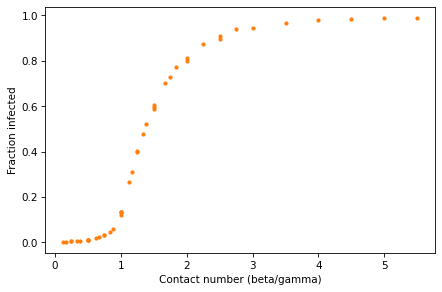

In [ ]:
from matplotlib.pyplot import plot

for gamma in frame.columns:
    column = frame[gamma]
    for beta in column.index:
        metric = column[beta]
        #print(beta, gamma, metric)

def plot_sweep_frame(frame):
    for gamma in frame.columns:
        column = frame[gamma]
        for beta in column.index:
            metric = column[beta]
            plot(beta/gamma, metric, '.', color='C1')

plot_sweep_frame(frame)

decorate(xlabel='Contact number (beta/gamma)',
         ylabel='Fraction infected')